In [258]:
# TO DO:
# - add land sea masks to map plots
# - get mean model temperatures at proxy locations for latitudanal band means

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xarray as xr
from cartopy import crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import numpy as np
import os
import glob

plt.rcParams['figure.figsize'] = (18, 10)

# figure resolution in DPI
figure_resolution = 300 

data_dir = './Figure_Data'

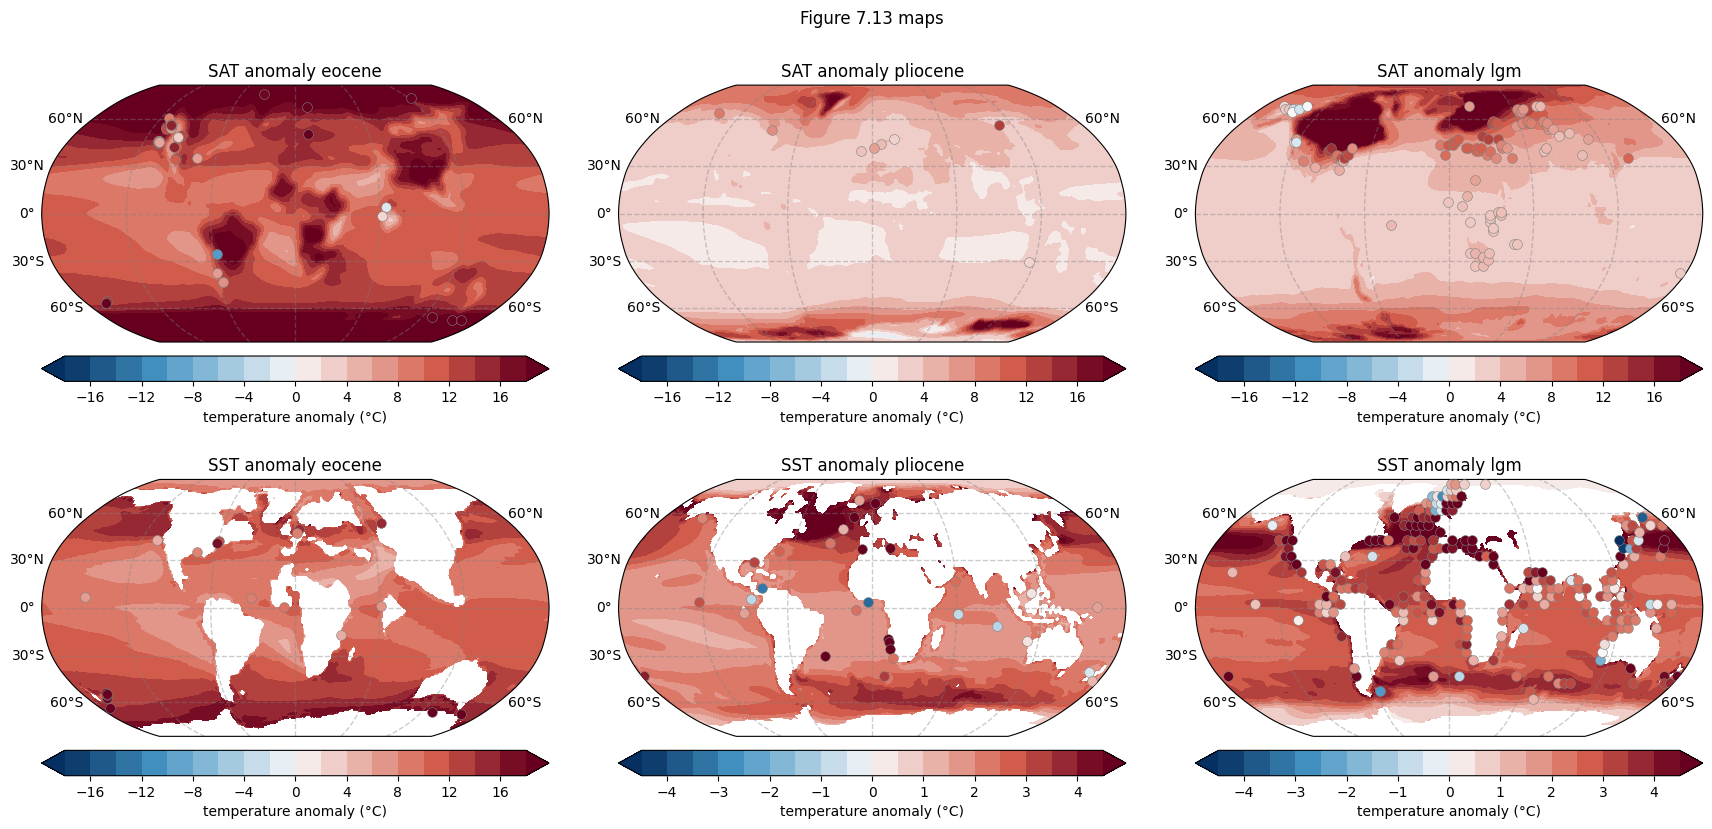

In [438]:
# maps
crs = ccrs.Robinson()
fig, ax = plt.subplots(2,3,subplot_kw=dict(projection=crs))

#ipcc colormap
#read the txt file
rgb_data_in_the_txt_file = np.loadtxt("ipcc_cmap_temp_div.txt")

#create the colormap
my_colormap = mcolors.LinearSegmentedColormap.from_list('colormap', rgb_data_in_the_txt_file)

fig.tight_layout(pad=5.0)
plt.suptitle('Figure 7.13 maps', y=0.88)

time_periods = ["eocene", "pliocene", "lgm"]
diff_labels = ["eo-pi", "pl-pi", "lg-pi"]

levels_high = range(-18,20,2)
levels_low = np.arange(-4.5,5.0,0.5)

for time_index,time in enumerate(time_periods):
    
# load SAT
    model_mean = xr.open_dataset(data_dir + "/Figure_7_13_mod/" + time + "/ensmean_" + diff_labels[time_index] + "_NearSurfaceTemperature.nc", decode_times = False)
    rank = len(model_mean.tas.shape)
    if rank == 2:
        tas_mean = model_mean.tas
    elif rank == 3:
        tas_mean = model_mean.tas[0,:,:]
    
    if time == "lgm":
        tas_mean *= -1.
    
    lon_idx = tas_mean.dims.index('longitude')
    wrap_data_tas, wrap_lon = add_cyclic_point(tas_mean.values, coord=tas_mean.longitude, axis=lon_idx)

# load SST
    model_mean = xr.open_dataset(data_dir + "/Figure_7_13_mod/" + time + "/ensmean_" + diff_labels[time_index] + "_SST.nc", decode_times = False)
    rank = len(model_mean.tos.shape)
    if rank == 2:
        tos_mean = model_mean.tos
    elif rank == 3:
        tos_mean = model_mean.tos[0,:,:]
    elif rank == 4:
        tos_mean = model_mean.tos[0,0,:,:]
        
    if time == "lgm":
        tos_mean *= -1.
    
    lon_idx = tos_mean.dims.index('longitude')
    wrap_data_tos, wrap_lon = add_cyclic_point(tos_mean.values, coord=tos_mean.longitude, axis=lon_idx)

    if time_index == 0:
        ens_field_sat_combined = tas_mean.squeeze()
        ens_field_tos_combined = tos_mean.squeeze()
    else:
        ens_field_sat_combined = xr.concat([ens_field_sat_combined, tas_mean.squeeze()], "exp", coords='minimal', compat='override')
        ens_field_tos_combined = xr.concat([ens_field_tos_combined, tos_mean.squeeze()], "exp", coords='minimal', compat='override')  
    
    cf = ax[0,time_index].contourf(wrap_lon, tas_mean.latitude, wrap_data_tas,
                                   transform=ccrs.PlateCarree(),
                                   levels = levels_high, 
                                   cmap=my_colormap, 
                                   extend='both' )
    
    cbar = fig.colorbar(cf, orientation = 'horizontal', pad = 0.03)
    cbar.set_label('temperature anomaly (°C)')

    if time == "eocene":
        levels_sst = levels_high
    else:
        levels_sst = levels_low
    
    cf = ax[1,time_index].contourf(wrap_lon, tos_mean.latitude, wrap_data_tos,
                                   transform=ccrs.PlateCarree(),
                                   levels = levels_sst, 
                                   cmap=my_colormap, 
                                   extend='both' )
    
    cbar = fig.colorbar(cf, orientation = 'horizontal', pad = 0.03)
    cbar.set_label('temperature anomaly (°C)')
    
    ax[0,time_index].set_title("SAT anomaly " + time)
    ax[1,time_index].set_title("SST anomaly " + time)
    
# point observations
df_obs = pd.read_csv(data_dir + '/Figure7_13_obs.csv', header=2)

for index, row in df_obs.iterrows():
    
    if row['Time Period'] == 'EECO':
        pcolumn = 0
    elif row['Time Period'] == 'MPWP':
        pcolumn = 1
    elif row['Time Period'] == 'LGM':
        pcolumn = 2

    if row['SST or SAT'] == 'SAT':
        prow = 0
        minmax = 20
    elif row['SST or SAT'] == 'SST':
        prow = 1
        if row['Time Period'] == 'EECO':
            minmax = 20
        else:
            minmax = 5.0
        
       
    ax[prow,pcolumn].scatter(row["longitude [degrees]"], row["latitude [degrees]"], marker = 'o', c=row["mean temperature [degreesC]"], edgecolors='gray', linewidth= 0.4, vmin=minmax*-1., vmax=minmax, cmap=my_colormap, s=50, zorder=4, transform=ccrs.PlateCarree())

for ax in ax.flat:
    gl = ax.gridlines(draw_labels=True,
                  linewidth=1, color='gray', alpha=0.4, linestyle='--')
    gl.right_labels = None
    gl.top_labels = None
    gl.bottom_labels = None
    
plt.savefig('new_figure_7.13_maps.png', dpi=figure_resolution, bbox_inches='tight')


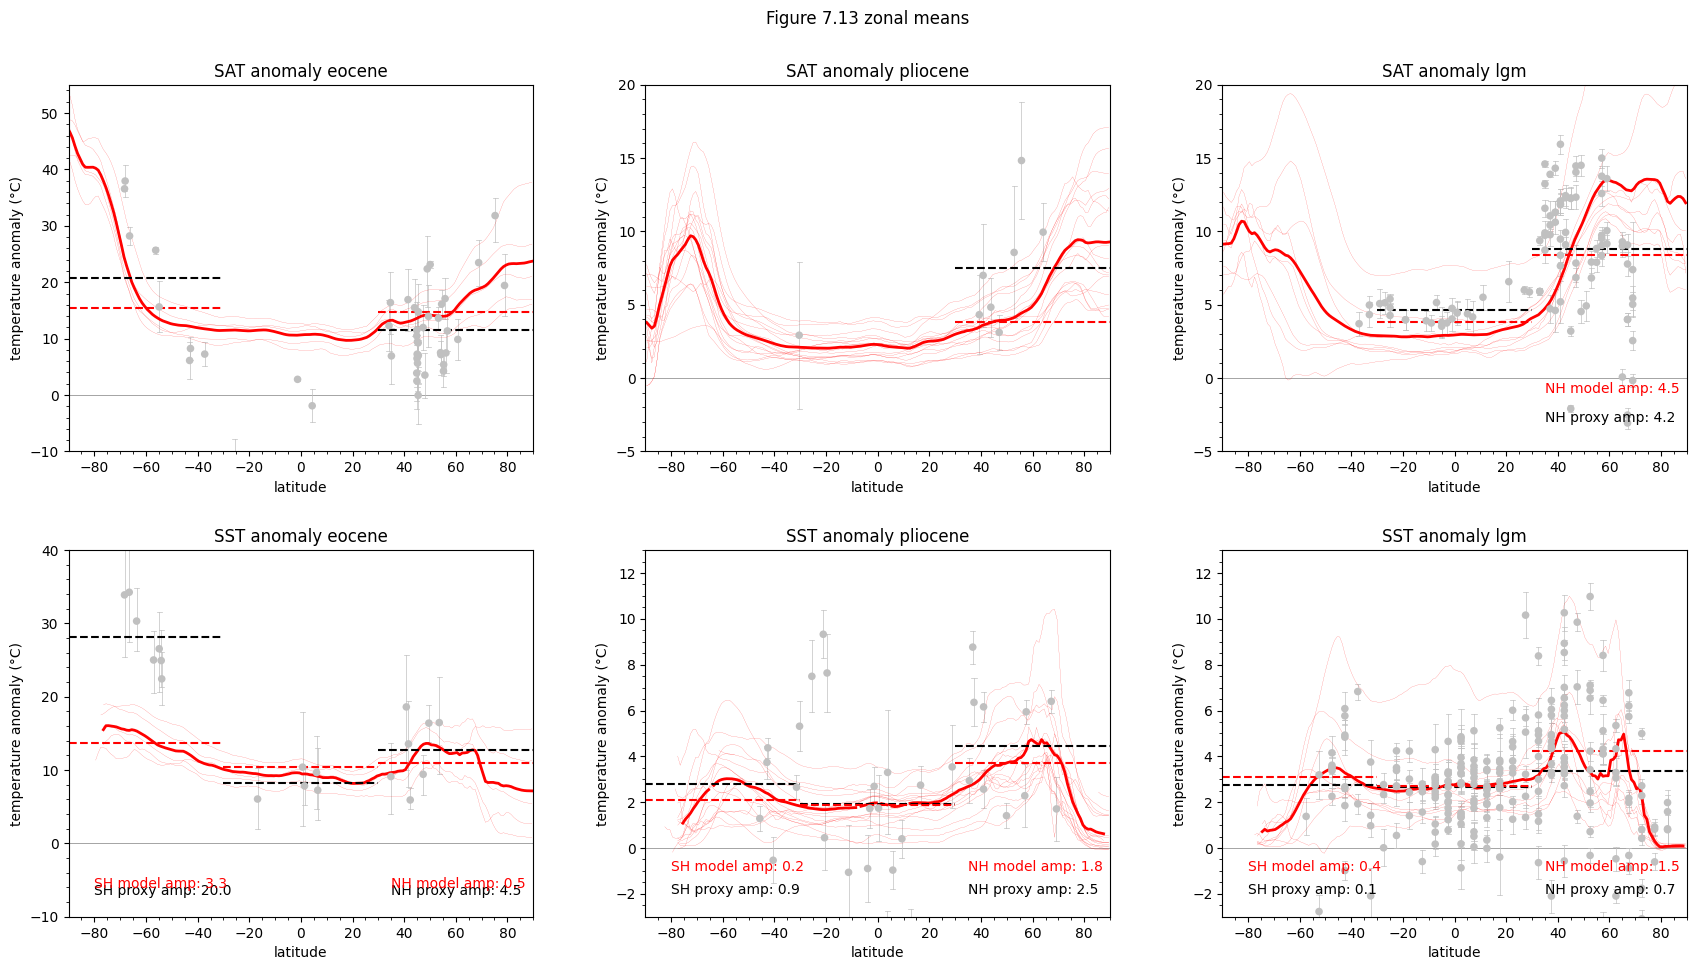

In [479]:
# zonal means

fig, ax = plt.subplots(2,3)

fig.tight_layout(pad=5.0)
plt.suptitle('Figure 7.13 zonal means', y=1.0)

ymin = [-10, -5, -5, -10, -3, -3]
ymax = [55, 20, 20, 40, 13, 13]

for time_index,time in enumerate(time_periods):

    lim = ax[0,time_index].set_ylim(ymin[time_index],ymax[time_index])
    lim = ax[1,time_index].set_ylim(ymin[time_index+3],ymax[time_index+3])
    
    # individual model zonal means
    # sat
    files_sat = glob.glob(data_dir + "/Figure_7_13_mod/" + time + "/mod_*_NearSurfaceTemperature_zonmean.nc")
    for file in files_sat:
        file_zm = xr.open_dataset(file, decode_times = False)
        if time == 'lgm':
            file_zm *= -1.0
        file_zm.tas.plot(ax=ax[0,time_index], c="red", linewidth=0.1)
        
    # sst
    files_tos = glob.glob(data_dir + "/Figure_7_13_mod/" + time + "/mod_*_SST_zonmean.nc")
    for file in files_tos:
        file_zm = xr.open_dataset(file, decode_times = False)
        if time == 'lgm':
            file_zm *= -1.0
        file_zm.tos.plot(ax=ax[1,time_index], c="red", linewidth=0.1)
    
    # ensemble mean
    ens_sat = xr.open_dataset(data_dir + "/Figure_7_13_mod/" + time + "/ensavg_" + diff_labels[time_index] + "_NearSurfaceTemperature_zonmean.nc", decode_times = False)
    if time == 'lgm':
        ens_sat *= -1.0

    ens_tos = xr.open_dataset(data_dir + "/Figure_7_13_mod/" + time + "/ensavg_" + diff_labels[time_index] + "_SST_zonmean.nc", decode_times = False)
    if time == 'lgm':
        ens_tos *= -1.0
    
    if time_index == 0:
        ens_sat_combined = ens_sat.squeeze()
        ens_tos_combined = ens_tos.squeeze()
    else:
        ens_sat_combined = xr.concat([ens_sat_combined, ens_sat.isel(bnds=0).squeeze()], "exp", coords='minimal', compat='override')
        ens_tos_combined = xr.concat([ens_tos_combined, ens_tos.isel(bnds=0).squeeze()], "exp", coords='minimal', compat='override')

# point observations
df_obs = pd.read_csv(data_dir + '/Figure7_13_obs.csv', header=2)

time_periods_short = ["EECO", "MPWP", "LGM"]

for time_index,time in enumerate(time_periods):
    ens_sat_combined.isel(exp=time_index).tas.plot(ax=ax[0,time_index], c="red", linewidth=2.0)
    ens_tos_combined.isel(exp=time_index).tos.plot(ax=ax[1,time_index], c="red", linewidth=2.0)
    
    # calculate proxy mean fopr each latitude band
    sp_proxy_values_tas = []
    ll_proxy_values_tas = []
    np_proxy_values_tas = []
    sp_proxy_values_sst = []
    ll_proxy_values_sst = []
    np_proxy_values_sst = []

    sp_model_values_tas = []
    ll_model_values_tas = []
    np_model_values_tas = []
    sp_model_values_sst = []
    ll_model_values_sst = []
    np_model_values_sst = []
    
    processed_lat = 0
    processed_lon = 0
    
    for index, row in df_obs.iterrows():
        # select current time period
        if row['Time Period'] == time_periods_short[time_index]:
            
            if row['latitude [degrees]'] == processed_lat and row['longitude [degrees]'] == processed_lon:
                print('duplicate proxy location found')
                break
            else:
                processed_lat = row['latitude [degrees]']
                processed_lon = row['longitude [degrees]']

            if row['latitude [degrees]'] <= -30.:
                if row['SST or SAT'] == 'SAT':
                    sp_proxy_values_tas.append(row['mean temperature [degreesC]'])
                    # get model mean at position
                    sp_model_values_tas.append(ens_field_sat_combined.sel(exp=time_index).sel(latitude=row['latitude [degrees]'], longitude=row['longitude [degrees]'], method='nearest').values)
                elif row['SST or SAT'] == 'SST':
                    sp_proxy_values_sst.append(row['mean temperature [degreesC]'])
                    # get model mean at position
                    sp_model_values_sst.append(ens_field_tos_combined.sel(exp=time_index).sel(latitude=row['latitude [degrees]'], longitude=row['longitude [degrees]'], method='nearest').values)
            elif row['latitude [degrees]'] < 30.:
                if row['SST or SAT'] == 'SAT':
                    ll_proxy_values_tas.append(row['mean temperature [degreesC]'])
                    # get model mean at position
                    ll_model_values_tas.append(ens_field_sat_combined.sel(exp=time_index).sel(latitude=row['latitude [degrees]'], longitude=row['longitude [degrees]'], method='nearest').values)
                elif row['SST or SAT'] == 'SST':
                    ll_proxy_values_sst.append(row['mean temperature [degreesC]'])
                    # get model mean at position
                    ll_model_values_sst.append(ens_field_tos_combined.sel(exp=time_index).sel(latitude=row['latitude [degrees]'], longitude=row['longitude [degrees]'], method='nearest').values)       
            elif row['latitude [degrees]'] >= 30.:
                if row['SST or SAT'] == 'SAT':
                    np_proxy_values_tas.append(row['mean temperature [degreesC]'])
                    # get model mean at position
                    np_model_values_tas.append(ens_field_sat_combined.sel(exp=time_index).sel(latitude=row['latitude [degrees]'], longitude=row['longitude [degrees]'], method='nearest').values)
                elif row['SST or SAT'] == 'SST':
                    np_proxy_values_sst.append(row['mean temperature [degreesC]'])
                    # get model mean at position
                    np_model_values_sst.append(ens_field_tos_combined.sel(exp=time_index).sel(latitude=row['latitude [degrees]'], longitude=row['longitude [degrees]'], method='nearest').values)       

    if len(sp_proxy_values_tas) >= 5:
        ax[0,time_index].plot([-90, -30], [np.mean(np.array(sp_proxy_values_tas)), np.mean(np.array(sp_proxy_values_tas))], c = "black", linestyle='dashed', linewidth=1.5, zorder=2)
        ax[0,time_index].plot([-90, -30], [np.mean(np.array(sp_model_values_tas)), np.mean(np.array(sp_model_values_tas))], c = "red", linestyle='dashed', linewidth=1.5, zorder=2)
    if len(ll_proxy_values_tas) >= 5:
        ax[0,time_index].plot([-30, 30], [np.mean(np.array(ll_proxy_values_tas)), np.mean(np.array(ll_proxy_values_tas))], c = "black", linestyle='dashed', linewidth=1.5, zorder=2)
        ax[0,time_index].plot([-30, 30], [np.mean(np.array(ll_model_values_tas)), np.mean(np.array(ll_model_values_tas))], c = "red", linestyle='dashed', linewidth=1.5, zorder=2)
    if len(np_proxy_values_tas) >= 5:
        ax[0,time_index].plot([30, 90], [np.mean(np.array(np_proxy_values_tas)), np.mean(np.array(np_proxy_values_tas))], c = "black", linestyle='dashed', linewidth=1.5, zorder=2)
        ax[0,time_index].plot([30, 90], [np.mean(np.array(np_model_values_tas)), np.mean(np.array(np_model_values_tas))], c = "red", linestyle='dashed', linewidth=1.5, zorder=2)

        
    if len(sp_proxy_values_sst) >= 5:
        ax[1,time_index].plot([-90, -30], [np.mean(np.array(sp_proxy_values_sst)), np.mean(np.array(sp_proxy_values_sst))], c = "black", linestyle='dashed', linewidth=1.5, zorder=2)
        ax[1,time_index].plot([-90, -30], [np.nanmean(np.array(sp_model_values_sst)), np.nanmean(np.array(sp_model_values_sst))], c = "red", linestyle='dashed', linewidth=1.5, zorder=2)
    if len(ll_proxy_values_sst) >= 5:
        ax[1,time_index].plot([-30, 30], [np.mean(np.array(ll_proxy_values_sst)), np.mean(np.array(ll_proxy_values_sst))], c = "black", linestyle='dashed', linewidth=1.5, zorder=2)
        ax[1,time_index].plot([-30, 30], [np.nanmean(np.array(ll_model_values_sst)), np.nanmean(np.array(ll_model_values_sst))], c = "red", linestyle='dashed', linewidth=1.5, zorder=2)
    if len(np_proxy_values_sst) >= 5:
        ax[1,time_index].plot([30, 90], [np.mean(np.array(np_proxy_values_sst)), np.mean(np.array(np_proxy_values_sst))], c = "black", linestyle='dashed', linewidth=1.5, zorder=2)
        ax[1,time_index].plot([30, 90], [np.nanmean(np.array(np_model_values_sst)), np.nanmean(np.array(np_model_values_sst))], c = "red", linestyle='dashed', linewidth=1.5, zorder=2)

        
    if len(np_proxy_values_tas) >= 5 and len(ll_proxy_values_tas) >= 5:
        ax[0,time_index].text(35,ymin[time_index]+2, f'NH proxy amp: {np.mean(np.array(np_proxy_values_tas))-np.mean(np.array(ll_proxy_values_tas)):.1f}' )
        ax[0,time_index].text(35,ymin[time_index]+4, f'NH model amp: {np.nanmean(np.array(np_model_values_tas))-np.nanmean(np.array(ll_model_values_tas)):.1f}', color='red' )

    if len(np_proxy_values_sst) >= 5 and len(ll_proxy_values_sst) >= 5:
        ax[1,time_index].text(35,ymin[time_index]+3, f'NH proxy amp: {np.mean(np.array(np_proxy_values_sst))-np.mean(np.array(ll_proxy_values_sst)):.1f}' )
        ax[1,time_index].text(35,ymin[time_index]+4, f'NH model amp: {np.nanmean(np.array(np_model_values_sst))-np.nanmean(np.array(ll_model_values_sst)):.1f}', color='red' )

    if len(sp_proxy_values_sst) >= 5 and len(ll_proxy_values_sst) >= 5:
        ax[1,time_index].text(-80,ymin[time_index]+3, f'SH proxy amp: {np.mean(np.array(sp_proxy_values_sst))-np.mean(np.array(ll_proxy_values_sst)):.1f}' )
        ax[1,time_index].text(-80,ymin[time_index]+4, f'SH model amp: {np.nanmean(np.array(sp_model_values_sst))-np.nanmean(np.array(ll_model_values_sst)):.1f}', color='red' )

    ax[0,time_index].set_title("SAT anomaly " + time)
    ax[1,time_index].set_title("SST anomaly " + time)


for index, row in df_obs.iterrows():
    
    if row['Time Period'] == 'EECO':
        pcolumn = 0
    elif row['Time Period'] == 'MPWP':
        pcolumn = 1
    elif row['Time Period'] == 'LGM':
        pcolumn = 2

    if row['SST or SAT'] == 'SAT':
        prow = 0
        minmax = 20
    elif row['SST or SAT'] == 'SST':
        prow = 1
        if row['Time Period'] == 'EECO':
            minmax = 20
        else:
            minmax = 5.0
        
       
    ax[prow,pcolumn].scatter( row["latitude [degrees]"], row["mean temperature [degreesC]"], marker = 'o', c="silver", edgecolors='none', s=30, zorder=2, )
    ax[prow,pcolumn].plot( [row["latitude [degrees]"],row["latitude [degrees]"]] , [row["mean temperature [degreesC]"] - row["lower error bar [degreesC]"], row["mean temperature [degreesC]"] + row["upper error bar [degreesC]"]], c="silver", linewidth=0.5, zorder=1)
    ax[prow,pcolumn].plot( [row["latitude [degrees]"]-1,row["latitude [degrees]"]+1] , [row["mean temperature [degreesC]"] + row["upper error bar [degreesC]"], row["mean temperature [degreesC]"] + row["upper error bar [degreesC]"]], c="silver", linewidth=0.5, zorder=1)
    ax[prow,pcolumn].plot( [row["latitude [degrees]"]-1,row["latitude [degrees]"]+1] , [row["mean temperature [degreesC]"] - row["lower error bar [degreesC]"], row["mean temperature [degreesC]"] - row["lower error bar [degreesC]"]], c="silver", linewidth=0.5, zorder=1)

for ax in ax.flat:
    ax.axhline(y=0, xmin=-90, xmax=90, c = "gray", linewidth=0.5, zorder=0)
    ax.set_xlim(-90, 90)
    ax.set_xlabel('latitude')
    ax.set_ylabel('temperature anomaly (°C)')
    ax.minorticks_on()

plt.savefig('new_figure_7.13_zonal_mean.png', dpi=figure_resolution, bbox_inches='tight')

    